# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [6]:
caffe.set_mode_gpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'

if not 'force_backward: true' in open(model_def).read():
    with open(model_def, 'a') as f:
        f.write('force_backward: true\n')

model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


### 3. Classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [8]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

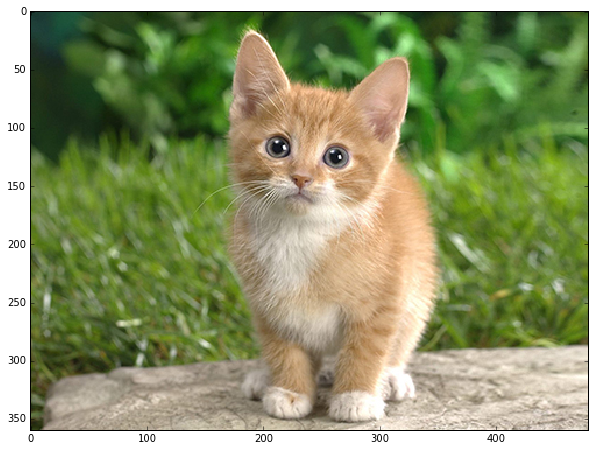

In [14]:
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

* Adorable! Let's classify it!

In [15]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()
print output['prob'].shape
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch
print output_prob.shape

print 'predicted class is:', output_prob.argmax()

(1, 1000)
(1000,)
predicted class is: 281


* The net gives us a vector of probabilities; the most probable class was the 281st one. But is that correct? Let's check the ImageNet labels...

In [16]:
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]

output label: n02123045 tabby, tabby cat


* "Tabby cat" is correct! But let's also look at other top (but less confident predictions).

### Grad-CAM Visualization
Now that we know that its label, let's use the grad-cam visualization technique to figure the most salient regions of the image for this label.

predicted class is: 281


(-0.5, 226.5, 226.5, -0.5)

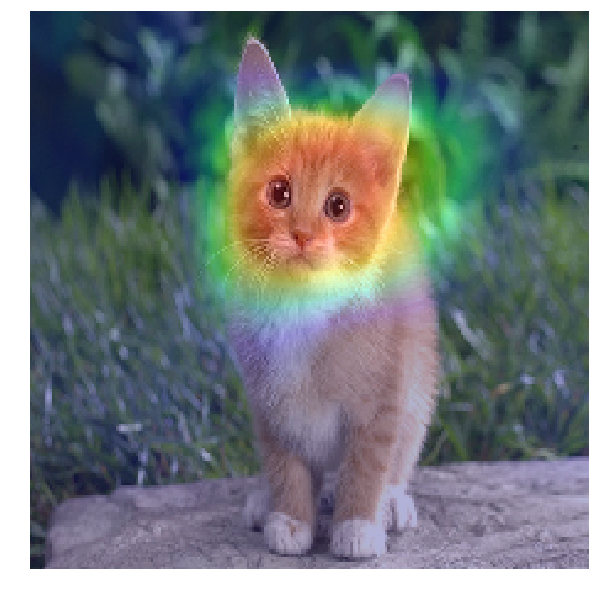

In [17]:
from PIL import Image
import matplotlib.cm as cm

#Perform a backward pass for the cat class (281)
net.blobs['data'].data[...] = transformed_image
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

label_index = output_prob.argmax()
caffeLabel = np.zeros((1,1000))
caffeLabel[0,label_index] = 1;

vis_layer = 'pool5' # visualization layer

grads=net.backward(diffs=[vis_layer],**{'prob':caffeLabel})
#bw=net.backward(diffs=[vis_layer],**{net.outputs[0]: caffeLabel})
vis_grad= grads['pool5'] # gradients of pool5 layer with respect to output class
vis_grad = np.squeeze(vis_grad) # removing the extra dimension
mean_grads = np.mean(vis_grad, axis=(1, 2)) # mean of gradients


activations = net.blobs[vis_layer].data
activations = np.squeeze(activations)
n_nodes = activations.shape[0] # number of nodels
vis_size = activations.shape[1:] #visualization shape
vis = np.zeros((6, 6), dtype=np.float32)


#generating saliency image
for i in xrange(n_nodes):
    activation = activations[i, :, :]
    weight = mean_grads[i]
    weighted_activation = activation*weight
    vis += weighted_activation

# We select only those activation which has positively contributed in prediction of given class

vis = np.maximum(vis, 0)   # relu
vis_img = Image.fromarray(vis, None)
vis_img = vis_img.resize((227,227),Image.BICUBIC)
vis_img = vis_img / np.max(vis_img)
vis_img = Image.fromarray(np.uint8(cm.jet(vis_img) * 255))
vis_img = vis_img.convert('RGB') # dropping alpha channel

image_path = caffe_root + 'examples/images/cat.jpg'
input_image = Image.open(image_path)
input_image = input_image.resize((227,227))
input_image = input_image.convert('RGB')
#plt.imshow(img)
#print vis_img.size, input_i
heat_map = Image.blend(input_image, vis_img, 0.3)
plt.imshow(heat_map)
plt.axis('off')

In [14]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilities and labels:


[(0.31244665, 'n02123045 tabby, tabby cat'),
 (0.23797087, 'n02123159 tiger cat'),
 (0.12387823, 'n02124075 Egyptian cat'),
 (0.10075197, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957191, 'n02127052 lynx, catamount')]

* We see that less confident predictions are sensible.

### 4. Switching to GPU mode

* Let's see how long classification took, and compare it to GPU mode.

In [17]:
%timeit net.forward()

1 loop, best of 3: 1.01 s per loop


* That's a while, even for a batch of 50 images. Let's switch to GPU mode.

In [18]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 50.1 ms per loop


* That should be much faster!

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [19]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(10, 3, 227, 227)
conv1	(10, 96, 55, 55)
pool1	(10, 96, 27, 27)
norm1	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
norm2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
conv4	(10, 384, 13, 13)
conv5	(10, 256, 13, 13)
pool5	(10, 256, 6, 6)
fc6	(10, 4096)
fc7	(10, 4096)
fc8	(10, 1000)
prob	(10, 1000)


* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [20]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

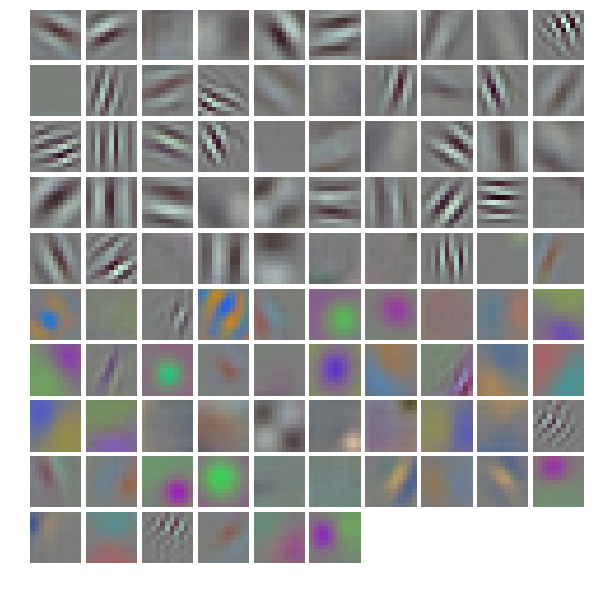

In [14]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

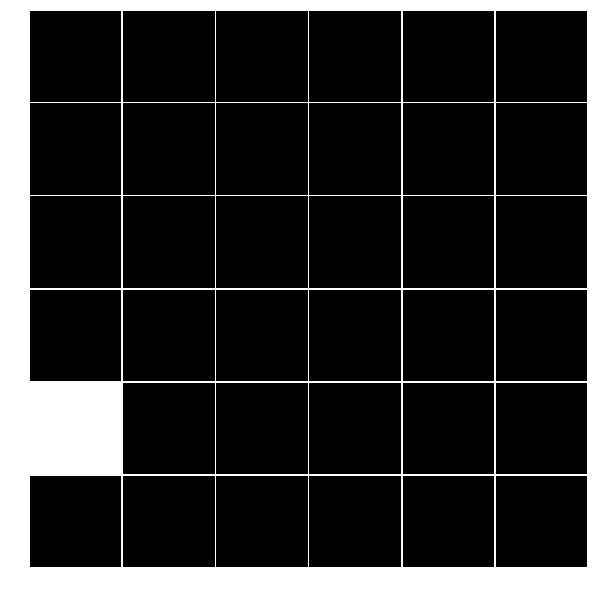

In [23]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat)

* The fifth layer after pooling, `pool5`

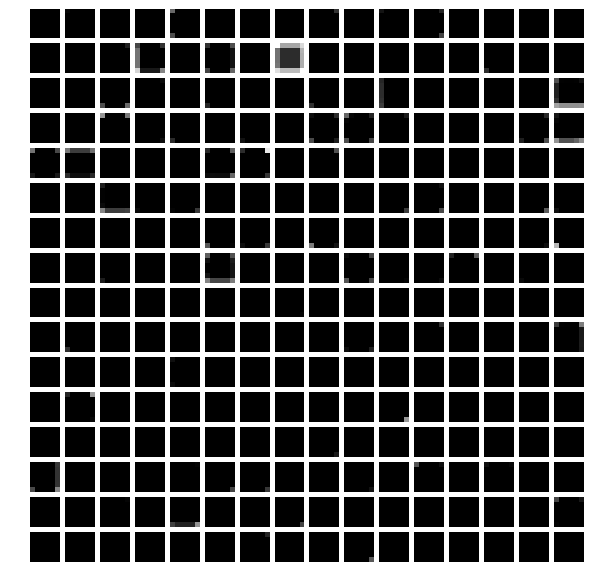

In [24]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

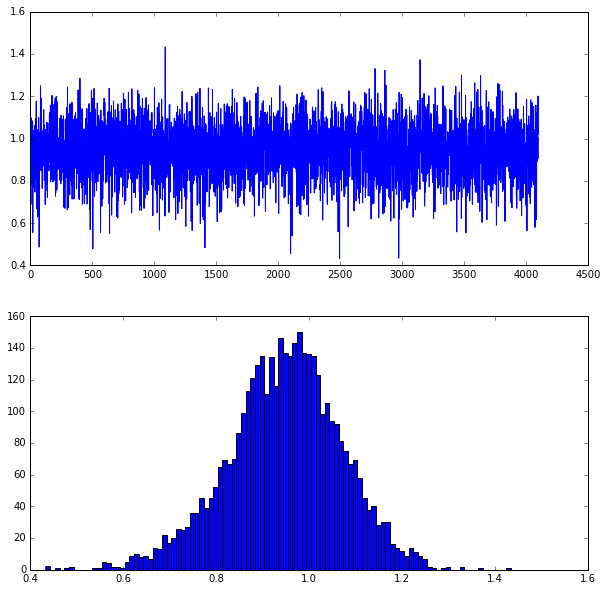

In [25]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

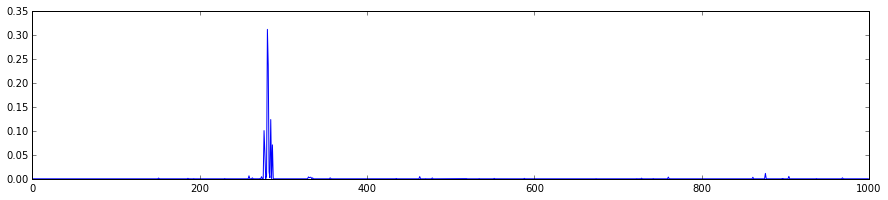

In [20]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.

### 6. Try your own image

Now we'll grab an image from the web and classify it using the steps above.

* Try setting `my_image_url` to any JPEG image URL.

In [26]:
# download an image
my_image_url = "..."  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

--2017-04-17 20:01:07--  http://.../
Resolving proxy.iiit.ac.in (proxy.iiit.ac.in)... 10.4.20.103
Connecting to proxy.iiit.ac.in (proxy.iiit.ac.in)|10.4.20.103|:8080... connected.
Proxy request sent, awaiting response... 503 Service Unavailable
2017-04-17 20:01:07 ERROR 503: Service Unavailable.



IOError: cannot identify image file <open file 'image.jpg', mode 'rb' at 0x7fc290acb420>